In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import math
import statsmodels.api as sm
plt.rcParams['savefig.dpi'] = 600
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec

## Importing the data

In [7]:
fit_exp_5FC = pd.read_csv("Supp_data/fit_promoters_5FC.csv")
fit_exp_comp = pd.read_csv("Supp_data/growth_exp_val_mutants.csv")  # 'Relative_median_exp' is from cytometry measurements
curves_ci_5FC = pd.read_csv("Supp_data/fit_functs_5FC.csv")
s_curve = pd.read_csv("Supp_data/s_curve_5FC.csv")

In [10]:
fit_exp_5FC

,Label,[5-FC] (uM),Median_Max_log_rate,Min_Max_log_rate,Max_Max_log_rate,Median_Median_rel_exp,Min_Median_rel_exp,Max_Median_rel_exp
0,Wild-type,3.0,0.230234,0.215933,0.245934,1.000000,0.970890,1.085457
1,Wild-type,12.0,0.178904,0.167644,0.189066,1.000000,0.970890,1.085457
2,Wild-type,24.0,0.160994,0.152486,0.163397,1.000000,0.970890,1.085457
3,Wild-type,48.0,0.128193,0.127925,0.130042,1.000000,0.970890,1.085457
4,pADH1,3.0,0.241079,0.238221,0.243695,1.670084,1.368832,1.760031
5,pADH1,12.0,0.185120,0.182056,0.188618,1.670084,1.368832,1.760031
6,pADH1,24.0,0.151390,0.151365,0.151415,1.670084,1.368832,1.760031
7,pADH1,48.0,0.118206,0.118002,0.118410,1.670084,1.368832,1.760031
8,pCUP1,3.0,0.238405,0.236576,0.241827,0.162806,0.149856,0.212960
9,pCUP1,12.0,0.191792,0.188853,0.195082,0.162806,0.149856,0.212960


In [15]:
# Preparing the data for the validation mutants
fit_exp_comp = fit_exp_comp[fit_exp_comp['Mutant_id'] != 'F3'].copy().reset_index(drop=True)
# F3 is removed because it had a growth defect in 5-FC while also growing better in SC

# Adding a new column identifying 'Promoter' 'CDS' mutations
fit_exp_comp['Location'] = fit_exp_comp['In_F3F4'].apply(lambda x: 'Promoter' if x else 'CDS')

# Computing error bars separately for the 'Promoter' and 'CDS' categories
comp_prom = fit_exp_comp[fit_exp_comp['Location'] == 'Promoter'].copy().reset_index(drop=True) 
comp_CDS = fit_exp_comp[fit_exp_comp['Location'] == 'CDS'].copy().reset_index(drop=True) 

# Error bars for prom mutations
exp_proms = np.array([comp_prom['Relative_median_exp'] - comp_prom['Min_rel_exp'],
                      comp_prom['Max_rel_exp'] - comp_prom['Relative_median_exp']])
growth_proms = np.array([comp_prom['Max_log_rate'] - comp_prom['Min_Max_log_rate'],
                         comp_prom['Max_Max_log_rate'] - comp_prom['Max_log_rate']])
s_proms = np.array([comp_prom['s_log'] - comp_prom['Min_s_log'],
                    comp_prom['Max_s_log'] - comp_prom['s_log']])

# Error bars for CDS mutations
exp_CDS = np.array([comp_CDS['Relative_median_exp'] - comp_CDS['Min_rel_exp'],
                    comp_CDS['Max_rel_exp'] - comp_CDS['Relative_median_exp']])
growth_CDS = np.array([comp_CDS['Max_log_rate'] - comp_CDS['Min_Max_log_rate'],
                       comp_CDS['Max_Max_log_rate'] - comp_CDS['Max_log_rate']])
s_CDS = np.array([comp_CDS['s_log'] - comp_CDS['Min_s_log'],
                  comp_CDS['Max_s_log'] - comp_CDS['s_log']])

## Generating the figure

In [17]:
dark2_palette = {'Wild-type': cm.Dark2.colors[1], 'pADH1': cm.Dark2.colors[2], 'pCUP1': cm.Dark2.colors[3],
               'pCYC1': cm.Dark2.colors[4], 'pGAL-L': cm.Dark2.colors[5], 'pTDH3': cm.Dark2.colors[6],
               'pTEF1': cm.Dark2.colors[7]}

mutants_palette = sns.color_palette('crest_r', 2)

plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11

C:\Users\tiger\AppData\Local\Temp\ipykernel_17800\1898824855.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter(comp_prom['Relative_median_exp'], comp_prom['s_log'], c=mutants_palette[1], zorder=3, edgecolor='black')


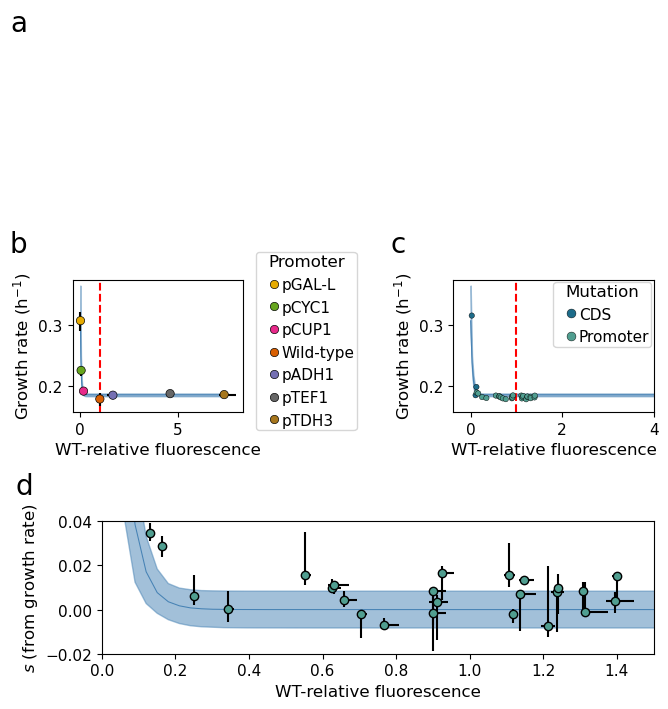

In [37]:
fig = plt.figure(constrained_layout=False, figsize=(7.5, 8))

gs = fig.add_gridspec(18, 20)

ax0 = fig.add_subplot(gs[0:4, 0:20])
ax1 = fig.add_subplot(gs[6:10, 0:6])
ax2 = fig.add_subplot(gs[6:10, 13:20], sharey=ax1)
ax3 = fig.add_subplot(gs[13:17, 1:20])

# Removing ticks for A, where a schematics will be added manually
ax0.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax0.spines[:].set_visible(False)

# Fitness function at 12 uM
IC50 = fit_exp_5FC[fit_exp_5FC['[5-FC] (uM)'] == 12].copy().sort_values(by='Median_Median_rel_exp').reset_index(drop=True)
x_IC50 = np.array([IC50['Median_Median_rel_exp'] - IC50['Min_Median_rel_exp'], IC50['Max_Median_rel_exp'] - IC50['Median_Median_rel_exp']])
y_IC50 = np.array([IC50['Median_Max_log_rate'] - IC50['Min_Max_log_rate'], IC50['Max_Max_log_rate'] - IC50['Median_Max_log_rate']])

sns.scatterplot(data=IC50, x='Median_Median_rel_exp', y='Median_Max_log_rate', hue='Label', ax=ax1, palette=dark2_palette, zorder=3, edgecolor='black')
ax1.errorbar(IC50['Median_Median_rel_exp'], IC50['Median_Max_log_rate'], xerr=x_IC50, yerr=y_IC50, fmt='none', zorder=2, ecolor='black')
ax1.plot(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['Median_decay_5FC_12'], c="steelblue", zorder=1, linewidth=0.75,)
ax1.fill_between(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['decay_5FC_12_2_5'],
                 curves_ci_5FC['decay_5FC_12_97_5'], alpha=0.5, color="steelblue", zorder=0)
ax1.axvline(x=1, linestyle='--', color='red', zorder=1)
h_1, l_1 = ax1.get_legend_handles_labels()
ax1.legend(h_1, l_1, handletextpad=-0.5, loc='upper left', title='Promoter', title_fontsize=12,
           bbox_to_anchor=(1.06, 1.225), fontsize=11, borderaxespad=0.15, borderpad=0.15)
ax1.set_ylabel(r"Growth rate (h$^{-1}$)", fontsize=12)
ax1.set_xlabel("WT-relative fluorescence", fontsize=12)
ax1.tick_params(axis='both', labelsize=11)

# Redoing the fitness function with the addition of validation mutants
ax2.plot(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['Median_decay_5FC_12'], c="steelblue", zorder=1, linewidth=0.75,)
ax2.fill_between(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['decay_5FC_12_2_5'],
                 curves_ci_5FC['decay_5FC_12_97_5'], alpha=0.5, color="steelblue", zorder=0)
ax2.axvline(x=1, linestyle='--', color='red', zorder=1)
ax2.set_xlim(right=4)

sns.scatterplot(data=fit_exp_comp, x='Relative_median_exp', y='Max_log_rate', hue='Location', palette=mutants_palette, edgecolor='black', ax=ax2, zorder=3, s=15,)
#ax2.errorbar(comp_CDS['Relative_median_exp'], comp_CDS['Max_log_rate'], xerr=exp_CDS, yerr=growth_CDS, fmt='none', zorder=2, ecolor='black', linewidth=2)
#ax2.errorbar(comp_prom['Relative_median_exp'], comp_prom['Max_log_rate'], xerr=exp_proms, yerr=growth_proms, fmt='none', zorder=2, ecolor='black', linewidth=2)
h_2, l_2 = ax2.get_legend_handles_labels()
ax2.legend(h_2, l_2, handletextpad=-0.5, loc='upper right', title='Mutation', title_fontsize=12,
           fontsize=11, borderaxespad=0.15, borderpad=0.15, markerscale=1.65)
ax2.set_ylabel(r"Growth rate (h$^{-1}$)", fontsize=12)
ax2.set_xlabel("WT-relative fluorescence", fontsize=12)
ax2.tick_params(axis='both', labelsize=11)

# Last panel (bottom): Zooming on F3-F4 validation mutants on the fitness function
ax3.scatter(comp_prom['Relative_median_exp'], comp_prom['s_log'], c=mutants_palette[1], zorder=3, edgecolor='black')
ax3.errorbar(comp_prom['Relative_median_exp'], comp_prom['s_log'], xerr=exp_proms, yerr=s_proms,
             fmt='none', ecolor='black', zorder=2)
ax3.plot(s_curve['Median_rel_exp'], s_curve['Median_decay_5FC_12'], c="steelblue", zorder=1, linewidth=0.75,)
ax3.fill_between(s_curve['Median_rel_exp'], s_curve['decay_5FC_12_2_5'],
                 s_curve['decay_5FC_12_97_5'], alpha=0.5, color="steelblue", zorder=0)
ax3.set_xlabel("WT-relative fluorescence", fontsize=12)
ax3.set_ylabel(r"$s$ (from growth rate)", fontsize=12)
ax3.tick_params(axis='both', labelsize=11)
ax3.set_xlim(left=0, right=1.5)
ax3.set_ylim(top=0.04, bottom=-0.02)

ax0.annotate('a', (-45, 125), xycoords='axes points', annotation_clip=False, fontsize=20)
ax1.annotate('b', (-45, 115), xycoords='axes points', annotation_clip=False, fontsize=20)
ax2.annotate('c', (-45, 115), xycoords='axes points', annotation_clip=False, fontsize=20)
ax3.annotate('d', (-62, 115), xycoords='axes points', annotation_clip=False, fontsize=20)


fig6 = plt.gcf()
fig6.savefig(f"Final_figs/Fig6_plt.tiff", bbox_inches='tight')

C:\Users\tiger\AppData\Local\Temp\ipykernel_17800\2390286204.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter(comp_prom['Relative_median_exp'], comp_prom['s_log'], c=mutants_palette[1], zorder=3, edgecolor='black')


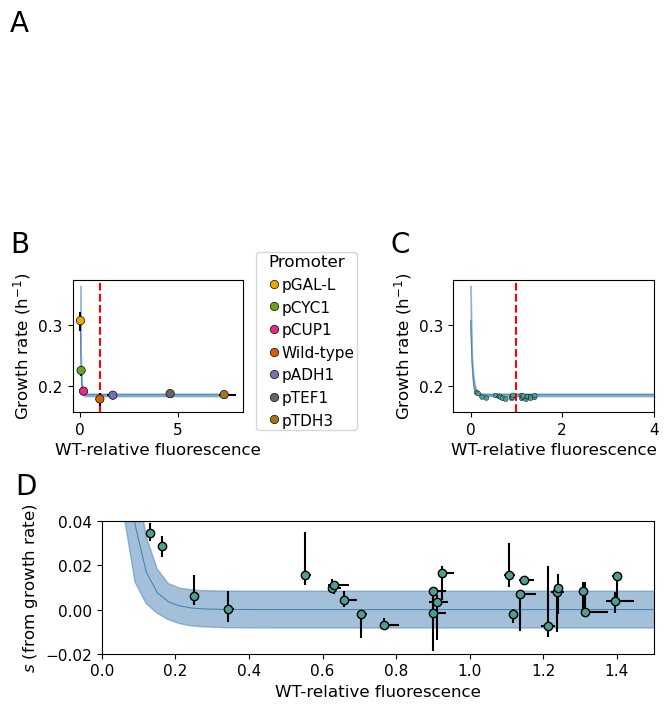

In [19]:
# Talk version
fig = plt.figure(constrained_layout=False, figsize=(7.5, 8))

gs = fig.add_gridspec(18, 20)

ax0 = fig.add_subplot(gs[0:4, 0:20])
ax1 = fig.add_subplot(gs[6:10, 0:6])
ax2 = fig.add_subplot(gs[6:10, 13:20], sharey=ax1)
ax3 = fig.add_subplot(gs[13:17, 1:20])

# Removing ticks for A, where a schematics will be added manually
ax0.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax0.spines[:].set_visible(False)

# Fitness function at 12 uM
IC50 = fit_exp_5FC[fit_exp_5FC['[5-FC] (uM)'] == 12].copy().sort_values(by='Median_Median_rel_exp').reset_index(drop=True)
x_IC50 = np.array([IC50['Median_Median_rel_exp'] - IC50['Min_Median_rel_exp'], IC50['Max_Median_rel_exp'] - IC50['Median_Median_rel_exp']])
y_IC50 = np.array([IC50['Median_Max_log_rate'] - IC50['Min_Max_log_rate'], IC50['Max_Max_log_rate'] - IC50['Median_Max_log_rate']])

sns.scatterplot(data=IC50, x='Median_Median_rel_exp', y='Median_Max_log_rate', hue='Label', ax=ax1, palette=dark2_palette, zorder=3, edgecolor='black')
ax1.errorbar(IC50['Median_Median_rel_exp'], IC50['Median_Max_log_rate'], xerr=x_IC50, yerr=y_IC50, fmt='none', zorder=2, ecolor='black')
ax1.plot(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['Median_decay_5FC_12'], c="steelblue", zorder=1, linewidth=0.75,)
ax1.fill_between(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['decay_5FC_12_2_5'],
                 curves_ci_5FC['decay_5FC_12_97_5'], alpha=0.5, color="steelblue", zorder=0)
ax1.axvline(x=1, linestyle='--', color='red', zorder=1)
h_1, l_1 = ax1.get_legend_handles_labels()
ax1.legend(h_1, l_1, handletextpad=-0.5, loc='upper left', title='Promoter', title_fontsize=12,
           bbox_to_anchor=(1.06, 1.225), fontsize=11, borderaxespad=0.15, borderpad=0.15)
ax1.set_ylabel(r"Growth rate (h$^{-1}$)", fontsize=12)
ax1.set_xlabel("WT-relative fluorescence", fontsize=12)
ax1.tick_params(axis='both', labelsize=11)

# Redoing the fitness function with the addition of validation mutants
ax2.plot(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['Median_decay_5FC_12'], c="steelblue", zorder=1, linewidth=0.75,)
ax2.fill_between(curves_ci_5FC['Median_rel_exp'], curves_ci_5FC['decay_5FC_12_2_5'],
                 curves_ci_5FC['decay_5FC_12_97_5'], alpha=0.5, color="steelblue", zorder=0)
ax2.axvline(x=1, linestyle='--', color='red', zorder=1)
ax2.set_xlim(right=4)

fit_comp_talk = fit_exp_comp[fit_exp_comp['Location'] == 'Promoter'].copy().reset_index(drop=True)
sns.scatterplot(data=fit_comp_talk, x='Relative_median_exp', y='Max_log_rate', hue='Location', palette=mutants_palette, edgecolor='black', ax=ax2, zorder=3, s=12,
               legend=False, hue_order=['CDS', 'Promoter'])
#ax2.errorbar(comp_CDS['Relative_median_exp'], comp_CDS['Max_log_rate'], xerr=exp_CDS, yerr=growth_CDS, fmt='none', zorder=2, ecolor='grey', linewidth=2)
#ax2.errorbar(comp_prom['Relative_median_exp'], comp_prom['Max_log_rate'], xerr=exp_proms, yerr=growth_proms, fmt='none', zorder=2, ecolor='grey')
ax2.set_ylabel(r"Growth rate (h$^{-1}$)", fontsize=12)
ax2.set_xlabel("WT-relative fluorescence", fontsize=12)
ax2.tick_params(axis='both', labelsize=11)

# Last panel (bottom): Zooming on F3-F4 validation mutants on the fitness function
ax3.scatter(comp_prom['Relative_median_exp'], comp_prom['s_log'], c=mutants_palette[1], zorder=3, edgecolor='black')
ax3.errorbar(comp_prom['Relative_median_exp'], comp_prom['s_log'], xerr=exp_proms, yerr=s_proms,
             fmt='none', ecolor='black', zorder=2)
ax3.plot(s_curve['Median_rel_exp'], s_curve['Median_decay_5FC_12'], c="steelblue", zorder=1, linewidth=0.75,)
ax3.fill_between(s_curve['Median_rel_exp'], s_curve['decay_5FC_12_2_5'],
                 s_curve['decay_5FC_12_97_5'], alpha=0.5, color="steelblue", zorder=0)
ax3.set_xlabel("WT-relative fluorescence", fontsize=12)
ax3.set_ylabel(r"$s$ (from growth rate)", fontsize=12)
ax3.tick_params(axis='both', labelsize=11)
ax3.set_xlim(left=0, right=1.5)
ax3.set_ylim(top=0.04, bottom=-0.02)

ax0.annotate('A', (-45, 125), xycoords='axes points', annotation_clip=False, fontsize=20)
ax1.annotate('B', (-45, 115), xycoords='axes points', annotation_clip=False, fontsize=20)
ax2.annotate('C', (-45, 115), xycoords='axes points', annotation_clip=False, fontsize=20)
ax3.annotate('D', (-62, 115), xycoords='axes points', annotation_clip=False, fontsize=20)


fig6_talk = plt.gcf()
fig6_talk.savefig(f"Final_figs/Fig6_talk.tiff", bbox_inches='tight')

In [45]:
fit_exp_comp[fit_exp_comp['Location'] == 'CDS'].shape

(3, 17)